<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/graphs/stanford-cs224w/assignments/assign-3/CS224W_Colab3_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 3**

In Colab 2 we constructed GNN models by using PyTorch Geometric's built in GCN layer, `GCNConv`. In this Colab we will go a step deeper and implement the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer directly. Then we will run our models on the CORA dataset, which is a standard citation network benchmark dataset.

**Note**: Make sure to **sequentially run all the cells in each section** so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 3 :)

# Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Installation

In [1]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 3.6 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=3233e32dadb4fe9f710be61a7eb7def0bfc5c1aebdee862a8295b6a8f5e1c589
  Stored in directory

  Preparing metadata (setup.py) ... done


In [2]:
import torch_geometric
torch_geometric.__version__

'2.2.0'

# 1) GNN Layers

## Implementing Layer Modules

In Colab 2, we implemented a GCN model for node and graph classification tasks. However, for that notebook we took advantage of PyG's built in GCN module. For Colab 3, we provide a build upon a general Graph Neural Network Stack, into which we will be able to plugin our own module implementations: GraphSAGE and GAT.

We will then use our layer implemenations to complete node classification on the CORA dataset, a standard citation network benchmark. In this dataset, nodes correspond to documents and edges correspond to undirected citations. Each node or document in the graph is assigned a class label and features based on the documents binarized bag-of-words representation. Specifically, the Cora graph has 2708 nodes, 5429 edges, 7 prediction classes, and 1433 features per node. 

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** (Colab 4) layers will function as components in the GNNStack Module.

In [4]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Creating Our Own Message Passing Layer

Now let's start implementing our own message passing layers! Working through this part will help us become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing us to build our own GNN models. To do so, we will work with and implement 3 critcal functions needed to define a PyG Message Passing Layer: `forward`, `message`, and `aggregate`.

Before diving head first into the coding details, let us quickly review the key components of the message passing process. To do so, we will focus on a single round of messsage passing with respect to a single central node $x$. Before message passing, $x$ is associated with a feature vector $x^{l-1}$, and the goal of message passing is to update this feature vector as $x^l$. To do so, we implement the following steps: 1) each neighboring node $v$ passes its current message $v^{l-1}$ across the edge $(x, v)$ - 2) for the node $x$, we aggregate all of the messages of the neighboring nodes (for example through a sum or mean) - and 3) we transform the aggregated information by for example applying linear and non-linear transformations. Altogether, the message passing process is applied such that every node $u$ in our graph updates its embedding by acting as the central node $x$ in step 1-3 described above. 


Now, we extending this process to that of a single message passing layer, the job of a message passing layer is to update the current feature representation or embedding of each node in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is: 1) pre-processing -> 2) **message passing** / propagation -> 3) post-processing. 

The `forward` fuction that we will implement for our message passing layer captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function. 


The `propagate` function encapsulates the message passing process! It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings outputed by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.

Lastly, before starting to implement our own layer, let us dig a bit deeper into each of the functions described above:

1. 

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Calling `propagate` initiates the message passing process. Looking at the function parameters, we highlight a couple of key parameters. 

  - `edge_index` is passed to the forward function and captures the edge structure of the graph.
  - `x=(x_i, x_j)` represents the node features that will be used in message passing. In order to explain why we pass the tuple `(x_i, x_j)`, we first look at how our edges are represented. For every edge $(i, j) \in {E}$, we can differentiate $i$ as the source or central node ($x_{central}$) and j as the neighboring node ($x_{neighbor}$). 
  
    Taking the example of message passing above, for a central node $u$ we will aggregate and transform all of the messages associated with the nodes $v$ s.t. $(u, v) \in {E}$ (i.e. $v \in \mathscr{N}_{u}$). Thus we see, the subscripts `_i` and `_j` allow us to specifcally differenciate features associated with central nodes (i.e. nodes  recieving message information) and neighboring nodes (i.e. nodes passing messages). 

    This is definitely a somewhat confusing concept; however, one key thing to remember / wrap your head around is that depending on the perspective, a node $x$ acts as a central node or a neighboring node. In fact, in undirected graphs we store both edge directions (i.e. $(i, j)$ and $(j, i)$). From the central node perspective, `x_i`, x is collecting neighboring information to update its embedding. From a neighboring node perspective, `x_j`, x is passing its message information along the edge connecting it to a different central node.

  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_i, param_j)` as we would like. Again, we highlight that indexing with `_i` and `_j` allows us to differentiate central and neighboring nodes. 

  The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $[N, d]$.

2. 
```
def message(x_j, ...):
```
The `message` function is called by propagate and constructs the messages from
neighboring nodes $j$ to central nodes $i$ for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially passed to `propagate`. Furthermore, we can again differentiate central nodes and neighboring nodes by appending `_i` or `_j` to the variable name, .e.g. `x_i` and `x_j`. Looking more specifically at the variables, we have:

  - `x_j` represents a matrix of feature embeddings for all neighboring nodes passing their messages along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in {E}$). Thus, its shape is $[|{E}|, d]$!
  - In implementing GAT we will see how to access additional variables passed to propagate

  Critically, we see that the output of the `message` function is a matrix of neighboring node embeddings ready to be aggregated, having shape $[|{E}|, d]$.

3. 
```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function is used to aggregate the messages from neighboring nodes. Looking at the parameters we highlight:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` has the same shape as `inputs` and tells us the central node that corresponding to each of the rows / messages $j$ in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node.

  The output of `aggregate` is of shape $[N, d]$.


For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GraphSage Implementation

For our first GNN layer, we will implement the well known GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) layer! 

For a given *central* node $v$ with current embedding $h_v^{l-1}$, the message passing update rule to tranform $h_v^{l-1} \rightarrow h_v^l$ is as follows: 

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

where $W_1$ and $W_2$ are learanble weight matrices and the nodes $u$ are *neighboring* nodes. Additionally, we use mean aggregation for simplicity:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

One thing to note is that we're adding a **skip connection** to our GraphSage implementation through the term $W_l\cdot h_v^{(l-1)}$. 

Before implementing this update rule, we encourage you to think about how different parts of the formulas above correspond with the functions outlined earlier: 1) `forward`, 2) `message`, and 3) `aggregate`. As a hint, we are given what the aggregation function is (i.e. mean aggregation)! Now the question remains, what are the messages passed by each neighbor nodes and when do we call the `propagate` function? 

Note: in this case the message function or messages are actually quite simple. Additionally, remember that the `propagate` function encapsulates the operations of / the outputs of the combined `message` and `aggregate` functions.


Lastly, $\ell$-2 normalization of the node embeddings is applied after each iteration.


<font color='red'>For the following questions, DON'T refer to any existing implementations online.</font>

In [5]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Don't forget the bias!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.lin_l = nn.Linear(in_features=in_channels, out_features=out_channels)
        self.lin_r = nn.Linear(in_features=in_channels, out_features=out_channels)

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x). 
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        #
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        out = self.lin_l(x) + self.propagate(edge_index=edge_index, size=size, x=(x, x))
        out = F.normalize(out, p=2) if self.normalize else out

        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on 
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = self.lin_r(x_j)

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(src=inputs, index=index, dim_size=dim_size, dim=node_dim, reduce="mean")

        ############################################################################

        return out


## Building Optimizers

This function has been implemented for you. **For grading purposes please use the default Adam optimizer**, but feel free to play with other types of optimizers on your own.

In [6]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [7]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Let's Start the Training!

We will be working on the CORA dataset on node-level classification.

This part is implemented for you. **For grading purposes, please do not modify the default parameters.** However, feel free to play with different configurations just for fun!

**Submit your best accuracy and loss on Gradescope.**

Processing...
Done!
/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:44<00:00, 11.27Epochs/s]


Maximum test set accuracy: 0.807
Minimum loss: 0.10239746421575546
Saving Model Predictions for Model Type GraphSage



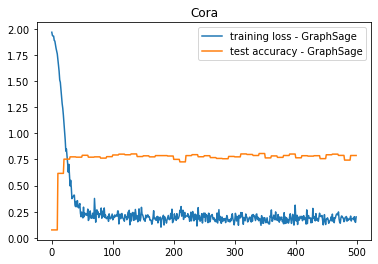

In [8]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 2
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


## Question 1.1: What is the maximum accuracy obtained on the test set for GraphSage? (10 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named *CORA-Node-GraphSage.csv*.  

As we have seen before you can view this file by clicking on the *Folder* icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.